## Loading Data

In [10]:
import os
import re
import ast
import typing
import requests
import icalendar
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import date, datetime
from icalendar import Calendar, Event, vCalAddress, vText

import xgboost as xgb
from xgboost import plot_importance

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

np.random.seed(31415)

sns.set(rc={'figure.figsize':(15,3)})
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
YEARS = [2023, 2022, 2021, 2020, 2019]
MONTHS = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [4]:
os.makedirs('./bicing', exist_ok=True)

if not len(os.listdir('./bicing')):
    i2m = list(zip(range(1,13), MONTHS))
    for year in YEARS:
        for month, month_name in i2m:        
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"mv '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.csv' './bicing' ")
            os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")

In [5]:
df = pd.DataFrame()

In [6]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(
        df['last_reported'].apply(lambda x: get_datetime(x))
    )
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    
    return df

In [7]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [10]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['station_id', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    # Create percentage of docks availability
    new_df['percentage_docks_available'] = new_df['num_docks_available'] / (new_df['num_docks_available'] + new_df['num_bikes_available'])

    return new_df

In [99]:
new_df

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl
0,1,9,9,0,35,1,1,1,1.590962e+09,True,IN_SERVICE,1590962425,2
1,2,22,22,0,3,1,1,1,1.590962e+09,True,IN_SERVICE,1590962425,2
2,3,12,12,0,15,1,1,1,1.590962e+09,True,IN_SERVICE,1590962425,2
3,4,9,9,0,12,1,1,1,1.590962e+09,True,IN_SERVICE,1590962425,2
4,5,31,31,0,7,1,1,1,1.590962e+09,True,IN_SERVICE,1590962425,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099859,514,5,5,0,11,1,1,1,1.593554e+09,True,IN_SERVICE,1593554116,18
4099860,515,16,15,1,5,1,1,1,1.593554e+09,True,IN_SERVICE,1593554116,18
4099861,516,21,21,0,0,1,1,1,1.593554e+09,True,IN_SERVICE,1593554116,18
4099862,517,8,6,2,16,1,1,1,1.593554e+09,True,IN_SERVICE,1593554116,18


In [11]:
def get_df_processed(df, file_name_csv: str = 'df_processed.csv'):
    if os.path.exists(file_name_csv):
        return pd.read_csv(file_name_csv)
        
    for csv in tqdm(os.listdir('./bicing')):
        new_df = pd.read_csv('./bicing/' + csv)
        new_df = process_new_df(new_df)

        # Filter out incorrect dates
        year, month, *_ = csv.split('_')
        year, month = int(year), int(month)
        new_df = new_df[(new_df.year == year) & (new_df.month == month)]

        df = pd.concat(
            [df, new_df], 
            axis=0
        )
    
    df.to_csv(file_name_csv, index=False, header=True)
    return df

df = get_df_processed(df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [07:52<00:00, 10.51s/it]


In [12]:
# Handle NaN: Assume that the NaN in traffic is 0
df.traffic = df.traffic.replace(np.nan, 0)

In [13]:
df.shape

(15098574, 21)

In [14]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic
1,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.824380,0.0
2,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.816434,0.0
3,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.823864,0.0
4,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.818182,0.0
5,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.818182,0.0


### Add station information

In [15]:
def get_station_json(
    url: str = 'https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download'
):
    
    res = requests.get(url)
    return res.json()

In [16]:
station_json = get_station_json()

In [17]:
station_df = pd.DataFrame(station_json['data']['stations'])
station_df.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,nearby_distance,_ride_code_support,rental_uris,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",08013,46,True,1000.0,True,None,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",08013,29,True,1000.0,True,None,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",08013,27,True,1000.0,True,None,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",08013,21,True,1000.0,True,None,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",08018,39,True,1000.0,True,None,NaN


In [18]:
# Some fields are not going to be used
station_drop_fields = [
    'physical_configuration',          # unique value: ELECTRICBIKESTATION
    '_ride_code_support',              # unique value: all True
    'nearby_distance',                 # unique value: 1000
    'name', 'address', 'post_code',    # too specific to each of the stations
    'is_charging_station',             # already in the main df
    'rental_uris', 'cross_street',     # vast majority are none
    
]

In [19]:
station_df = station_df.drop(station_drop_fields, axis=1)
station_df.head()

,station_id,lat,lon,altitude,capacity
0,1,41.397978,2.180107,16.0,46
1,2,41.395488,2.177198,17.0,29
2,3,41.394156,2.181331,11.0,27
3,4,41.393317,2.181248,8.0,21
4,5,41.391103,2.180176,7.0,39


In [20]:
df = pd.merge(df, station_df, how='left') # TODO: Handle NaN station information

In [21]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.824380,0.0,41.397978,2.180107,16.0,46.0
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.816434,0.0,41.397978,2.180107,16.0,46.0
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.823864,0.0,41.397978,2.180107,16.0,46.0
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0


### Add Weather information

Add information relative to the wather ([source](https://www.visualcrossing.com/weather/weather-data-services#))


In [22]:
print('Start date: ', df['date'].min())
print('End date: ', df['date'].max())

Start date:  2019-07-01
End date:  2023-05-31


In [23]:
def weather_api_extraction(url: str) -> pd.DataFrame:
    response = requests.get(url)
    response_json = response.json()
    
    weather_df = pd.json_normalize(response_json['days'])
    
    return weather_df

In [24]:
def weather_df_drop_columns(
    weather_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'datetimeEpoch', 
        'tzoffset', 
        'source',
        'name',                     # all barcelona
        'stations',                 # which stations tracked that weather
        'severerisk'                # all nulls
        'precipprob',               # 100 if it rains, 0 otherwise. Doesn't add new info
        'preciptype',               # 'rain' if it rains, 'snow' if it snows. Doesn't add new info
        'sunrise', 'sunset',        # simplify variables, too specific
        'description',              # simplify variables, too specific
        'sunrise',                  # simplify variables, too specific
        'sunset',                   # simplify variables, too specific
        'moonphase',                # simplify variables, too specific
        'sealevelpressure',         # simplify variables, too specific
    ]
):
    
    return weather_df.drop(columns_to_drop, axis=1, errors='ignore')

In [25]:
def process_weather_df(weather_df: pd.DataFrame) -> pd.DataFrame:
    weather_df.datetime = pd.to_datetime(weather_df.datetime)
    weather_df['date'] = weather_df.datetime.dt.date
    
    return weather_df

In [26]:
os.makedirs('./weather', exist_ok=True)

if not len(os.listdir('./weather')):
    weather_url1 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2019-03-28/2021-11-30?unitGroup=metric&include=days&key=4T9KXABWNUV92K2WTZMA7JXZ3&contentType=json'
    weather_df1 = weather_api_extraction(weather_url1)
    weather_df1.to_csv('./weather/weather_2019_03_28_to_2021_11_30.csv', index=False, header=True)
    
    weather_url2 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2021-12-01/2023-04-30?unitGroup=metric&include=days&key=6NT6N8CRPMNTAEE2FH2EQZ98U&contentType=json'
    weather_df2 = weather_api_extraction(weather_url2)
    weather_df2.to_csv('./weather/weather_2021_12_01_to_2023_04_30.csv', index=False, header=True)

else:
    weather_df1 = pd.read_csv('./weather/weather_2019_03_28_to_2021_11_30.csv')
    weather_df2 = pd.read_csv('./weather/weather_2021_12_01_to_2023_04_30.csv')   

In [27]:
weather_df = pd\
    .concat([weather_df1, weather_df2], axis=0)\
    .reset_index(drop=True)

In [28]:
weather_df = weather_df_drop_columns(weather_df)
weather_df = process_weather_df(weather_df)

In [29]:
weather_df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,date
0,2019-03-28,16.8,6.4,12.1,16.8,3.7,11.5,4.4,60.6,0.0,0.0,0.0,0.0,0.0,21.5,17.3,42.8,1027.6,1.1,16.1,221.4,19.2,7.0,1553751710,1553796707,Clear,clear-day,NaN,2019-03-28
1,2019-03-29,16.3,8.8,12.8,16.3,6.7,12.6,5.1,60.6,0.0,0.0,0.0,0.0,0.0,24.8,19.8,76.9,1027.2,8.9,16.1,222.3,19.1,7.0,1553838009,1553883172,Clear,clear-day,NaN,2019-03-29
2,2019-03-30,16.0,6.4,12.0,16.0,4.2,11.6,5.8,66.0,0.0,0.0,0.0,0.0,0.0,24.3,19.1,79.9,1023.8,29.4,15.5,224.5,19.6,7.0,1553924308,1553969637,Partially cloudy,partly-cloudy-day,NaN,2019-03-30
3,2019-03-31,15.9,8.4,12.5,15.9,6.9,12.4,7.9,73.5,0.0,0.0,0.0,0.0,0.0,37.6,31.2,71.2,1017.5,50.3,14.7,154.2,12.8,6.0,1554010607,1554056102,Partially cloudy,partly-cloudy-day,NaN,2019-03-31
4,2019-04-01,17.3,9.8,13.8,17.3,9.0,13.7,6.1,60.7,0.0,0.0,0.0,0.0,0.0,23.4,18.1,126.5,1015.2,35.0,15.3,214.7,18.6,7.0,1554096907,1554142567,Partially cloudy,partly-cloudy-day,NaN,2019-04-01


In [30]:
df.date = pd.to_datetime(df.date).dt.date
weather_df.date = pd.to_datetime(weather_df.date).dt.date

df = pd.merge(df, weather_df, left_on='date', right_on='date', how='left')

In [31]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.824380,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.816434,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.823864,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN


### Add Covid Information

The daily covid cases that there were in Barcelona ([source](https://www.amb.cat/en/web/area-metropolitana/dades-obertes/cataleg/detall/-/dataset/covid-19-positive-cases/9147624/11692))

In [32]:
def get_covid_json(
    url: str = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql=SELECT%20*%20from%20%22f627ac0a-d05f-416d-9773-eeb464a3fc44%22%20WHERE%20%22Nom_Indicador%22%20LIKE%20%27Casos%20de%20COVID-19%20a%20Barcelona%20(diari)%27"
):
    
    res_covid = requests.get(url)
    return res_covid.json()['result']['records']

In [33]:
covid_json = get_covid_json()

In [34]:
covid_df = pd.DataFrame(covid_json)
covid_df.head()

,Nom_Variable,Font,Data_Indicador,Territori,_full_text,Frequencia_Indicador,Valor,_id,Nom_Indicador,Unitat
0,,Agència de Salut Pública de Barcelona,2020-02-25,Barcelona,'-02':11 '-19':16 '-25':12 '1':9 '2020':10 'ag...,diari,1,1,Casos de COVID-19 a Barcelona (diari),Nombre
1,,Agència de Salut Pública de Barcelona,2020-02-26,Barcelona,'-02':11 '-19':17 '-26':12 '0':9 '2020':10 'ag...,diari,0,2,Casos de COVID-19 a Barcelona (diari),Nombre
2,,Agència de Salut Pública de Barcelona,2020-02-27,Barcelona,'-02':11 '-19':17 '-27':12 '0':9 '2020':10 'ag...,diari,0,3,Casos de COVID-19 a Barcelona (diari),Nombre
3,,Agència de Salut Pública de Barcelona,2020-02-28,Barcelona,'-02':19 '-19':13 '-28':20 '0':9 '2020':18 'ag...,diari,0,4,Casos de COVID-19 a Barcelona (diari),Nombre
4,,Agència de Salut Pública de Barcelona,2020-02-29,Barcelona,'-02':19 '-19':14 '-29':20 '0':9 '2020':18 'ag...,diari,0,5,Casos de COVID-19 a Barcelona (diari),Nombre


In [35]:
covid_df.shape

(773, 10)

In [36]:
covid_df = covid_df[['Data_Indicador', 'Valor']]
covid_df.head()

,Data_Indicador,Valor
0,2020-02-25,1
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,0
4,2020-02-29,0


In [37]:
covid_df['date'] = pd.to_datetime(covid_df.Data_Indicador).dt.date

In [38]:
covid_df = covid_df\
    .drop('Data_Indicador', axis=1)\
    .rename(columns={'Valor': 'covid_cases'})

In [39]:
covid_df.head()

,covid_cases,date
0,1,2020-02-25
1,0,2020-02-26
2,0,2020-02-27
3,0,2020-02-28
4,0,2020-02-29


In [40]:
df = pd.merge(
    df, 
    covid_df, 
    how='left', 
    left_on='date', 
    right_on='date'
)

We only have NaN values afterwards (not previous to the start of Covid).

For those NaN, we will replace them by a percentile that is at the bottom (still not 0, as there are cases).

In [41]:
df.covid_cases = df.covid_cases.astype('float')

In [42]:
df.covid_cases.describe()

count    7.882314e+06
mean     6.792263e+02
std      1.279695e+03
min      0.000000e+00
25%      8.400000e+01
50%      2.520000e+02
75%      5.870000e+02
max      8.656000e+03
Name: covid_cases, dtype: float64

<Axes: >

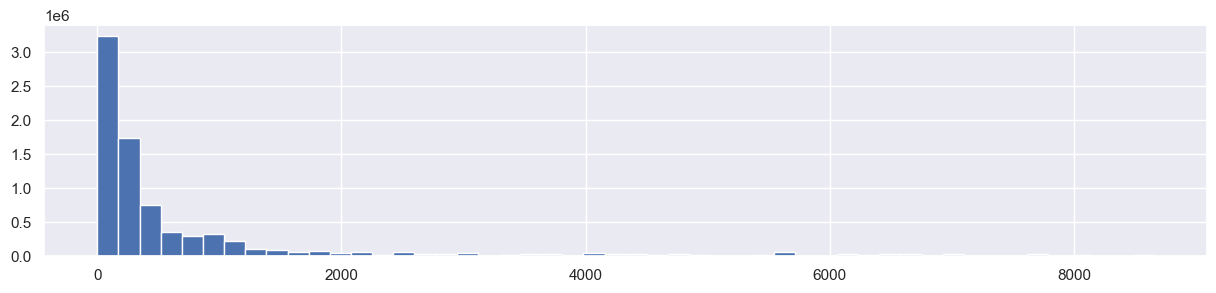

In [43]:
df.covid_cases.hist(bins=50)

In [44]:
def fill_with_percentile(
    df: pd.DataFrame, 
    column: str, 
    percentile: float = 0.03,
    logging: bool = True
):
    
    quantile_value = df[column].quantile(percentile)
    
    if logging:
        print(f'Percentile {percentile} value is: ', quantile_value)
        
    df[column] = df[column].fillna(quantile_value)
    
    return df

In [45]:
df = fill_with_percentile(df, 'covid_cases')

Percentile 0.03 value is:  5.0


In [212]:
COVID_CASES_IMPUTER_NULL = 5

We could add also information about in which dates the people where closed into their homes.

In [47]:
confinment_start = '2020-03-14'
confinment_date_start = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [48]:
confinment_end = '2020-06-21'
confinment_date_end = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [49]:
index_non_confinment = df[
    (df['date'] < confinment_date_start) |
    (df['date'] > confinment_date_end)
].index

In [50]:
df.loc[index_non_confinment, 'confinment'] = 0
df['confinment'] = df['confinment'].fillna(1)
df['confinment'] = df['confinment'].astype('int')

### Barcelona Events

This dataset seems incomplete as yearly events are not repeated. So will not be used for the final model.

In [51]:
os.makedirs('./events', exist_ok=True)

In [52]:
def get_opendataevents_json(url: str = 'https://www.bcn.cat/tercerlloc/files/opendatabcn_agenda.json'):
    res = requests.get(url)
    return res.json()

In [53]:
if not os.path.isfile('./events/opendatabcn_agenda.json'):
    events_json = get_opendataevents_json()
    events_df = pd.DataFrame(events_json)
    events_df.to_csv('./events/opendatabcn_agenda.json', index=False, header=True)

else:
    events_df = pd.read_csv('./events/opendatabcn_agenda.json')

In [54]:
events_df.head()

,register_id,prefix,suffix,name,created,modified,status,status_name,core_type,core_type_name,body,tickets_data,addresses,entity_types_data,attribute_categories,values,from_relationships,to_relationships,classifications_data,secondary_filters_data,timetable,image_data,gallery_data,warnings,geo_epgs_25831,geo_epgs_23031,geo_epgs_4326,is_section_of_data,sections_data,start_date,end_date,estimated_dates,languages_data,type,type_name,period,period_name,event_status_name,event_status,ical
0,99400629715,NaN,NaN,Mercat de Pagès a Vallcarca i els Penitents,2019-06-13T15:01:08+02:00,2023-05-19T10:08:59.023978+02:00,published,Publicat,event,Agenda,"<p>Parades de productes ecològics, de proximit...","[{'id': 3, 'name': 'Lliure'}]","[{'place': 'plaça del metro de Vallcarca', 'di...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 114759, 'value': 'http://www.facebook....",[],[],"[{'id': 2027, 'name': 'Petits mercats ocasiona...","[{'id': 400015, 'name': 'Petits mercats ocasio...","{'id': 27971, 'html': '<table class=""timetable...",NaN,[],"[{'id': 6991, 'text': '<p>Revisió</p>', 'type'...","{'x': 428555.9788206734, 'y': 4584832.783654237}","{'x': 428650.506964528, 'y': 4585037.344061564}","{'x': 41.411870483560705, 'y': 2.1451632515859...",NaN,NaN,2019-10-03T00:00:00+02:00,NaN,NaN,"[{'id': 1, 'language': 'Indiferent'}]",permanent,Permanent,NaN,NaN,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
1,99400622344,Campanya Vacances Estiu 2023,NaN,Casal esportiu 'Parkour i acrobàcies' per a in...,2019-03-13T09:45:46+01:00,2023-04-28T11:31:05.717773+02:00,published,Publicat,event,Agenda,<p>Campus de parkour i acrobàcies.</p><p>Insta...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': 'Institut Salvador Seguí', 'distric...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 114449, 'value': 'http://www.fip3.com/...","[{'type_id': 1002, 'name': 'se celebra a', 'en...",[],"[{'id': 2074000, 'name': 'Casals esportius', '...","[{'id': 524005, 'name': 'Actes per nens i nene...","{'id': 27304, 'html': '<table class=""timetable...",NaN,[],"[{'id': 12778, 'text': ""<p>Inscripcions a la w...","{'x': 432882.3765611512, 'y': 4586037.508796598}","{'x': 432976.8955911235, 'y': 4586242.10391194}","{'x': 41.42309401778554, 'y': 2.196790431984144}",NaN,NaN,2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00,NaN,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
2,99400622349,Campanya Vacances Estiu 2023,NaN,Casal/Campus Esportiu 'Futbol Sala' per a infa...,2019-03-13T09:54:13+01:00,2023-04-28T11:30:57.736367+02:00,published,Publicat,event,Agenda,<p>CAMPUS DE TECNIFICACIÓ FUTBOL SALA Instal·l...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': 'Institut Salvador Seguí', 'distric...","[{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...","[{'id': 2, 'name': ""Informació d'interès"", 'at...","[{'id': 113819, 'value': 'http://www.fip3.com/...","[{'type_id': 1002, 'name': 'se celebra a', 'en...",[],"[{'id': 2000, 'name': 'Campus', 'full_path': '...","[{'id': 524005, 'name': 'Actes per nens i nene...","{'id': 27305, 'html': '<table class=""timetable...",NaN,[],"[{'id': 12668, 'text': ""<p>Inscripcions a la w...","{'x': 432882.3765611512, 'y': 4586037.508796598}","{'x': 432976.8955911235, 'y': 4586242.10391194}","{'x': 41.42309401778554, 'y': 2.196790431984144}",NaN,NaN,2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00,NaN,"[{'id': 1, 'language': 'Indiferent'}]",repetitive,Cíclic,1.0,anual,Correcte,ok,BEGIN:VCALENDAR\r\nPRODID:ics.py - http://git....
3,99400076147,NaN,NaN,Exposició d'art contemporani,2004-03-09T12:49:22+01:00,2022-09-17T06:13:07.492957+02:00,published,Publicat,event,Agenda,<p>Aquest museu té un fons artístic de més de ...,"[{'id': 4, 'name': 'Pagament'}]","[{'place': None, 'district_name': 'Sants-Montj...","[{'id': 101, 'name': 'agenda'}, {'i

In [55]:
# Only having active dates
events_df = events_df[events_df.core_type_name != 'Equipament']
events_df = events_df[events_df.event_status == 'ok']

In [56]:
def events_df_drop_columns(
    events_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'register_id', 'prefix', 'suffix', 'name', 'created', 'modified', 'status', 'status_name',     # too specific
        'core_type', 'core_type_name',                                                                 # most is only one type of value
        'body', 'tickets_data', 'addresses', 'entity_types_data', 'attribute_categories', 'values',
        'from_relationships', 'to_relationships', 'classifications_data', 'secondary_filters_data',
        'timetable', 'image_data', 'gallery_data', 'warnings',                                         # unuseful information
        'is_section_of_data', 'sections_data', 'estimated_dates', 'languages_data', 'type', 'type_name',
        'period', 'period_name', 'event_status_name', 'event_status', 'ical',
        'geo_epgs_25831', 'geo_epgs_23031'                                                             # unwanted loations
    ]
):
    
    return events_df.drop(columns_to_drop, axis=1, errors='ignore')

In [57]:
# Drop columns not wanted
events_df = events_df_drop_columns(events_df)

In [58]:
# Drop events with not enough data
events_df.dropna(
    axis=0, 
    how='any', 
    subset=['geo_epgs_4326', 'start_date'], 
    inplace=True
)

In [59]:
events_df.head()

,geo_epgs_4326,start_date,end_date
0,"{'x': 41.411870483560705, 'y': 2.1451632515859...",2019-10-03T00:00:00+02:00,NaN
1,"{'x': 41.42309401778554, 'y': 2.196790431984144}",2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00
2,"{'x': 41.42309401778554, 'y': 2.196790431984144}",2023-06-26T03:00:00+02:00,2023-08-04T03:00:00+02:00
4,"{'x': 41.42214155134015, 'y': 2.1658503000743763}",2023-07-17T03:00:00+02:00,2023-07-28T03:00:00+02:00
5,"{'x': 41.37192068979768, 'y': 2.1701826605872294}",2009-10-01T00:00:00+02:00,NaN


In [60]:
def get_event_geographics(geo_position: str):
    geo_position = ast.literal_eval(geo_position)
    return geo_position['x'], geo_position['y']

In [61]:
events_geographic_x_y = events_df.geo_epgs_4326.apply(lambda x: get_event_geographics(str(x)))
events_df['x'] = [x for x, _ in events_geographic_x_y]
events_df['y'] = [y for _, y in events_geographic_x_y]

events_df = events_df[events_df.x > 0]
events_df = events_df[events_df.y > 0]

events_df.drop(['geo_epgs_4326'], axis=1, inplace=True)

In [62]:
# In the case of null values of end date, we will assume is the same as start date (we will consider only days)
events_df.end_date.fillna(events_df.start_date, inplace=True)

In [63]:
events_df['start_date'] = pd.to_datetime(events_df['start_date'], utc=True).dt.date
events_df['end_date'] = pd.to_datetime(events_df['end_date'], utc=True).dt.date

In [64]:
# Filter out by maximum and minimum dates of df
df_min_date, df_max_date = df.date.min(), df.date.max()

events_df = events_df[events_df.start_date > df_min_date]
events_df = events_df[events_df.end_date < df_max_date]

In [65]:
print(events_df.shape)
events_df.head()

(87, 4)


,start_date,end_date,x,y
0,2019-10-02,2019-10-02,41.411870,2.145163
31,2020-07-14,2020-07-14,41.380700,2.185521
32,2020-07-15,2020-07-15,41.386661,2.171438
74,2023-01-01,2023-01-01,41.400303,2.202462
133,2022-11-03,2022-11-03,41.371326,2.149594


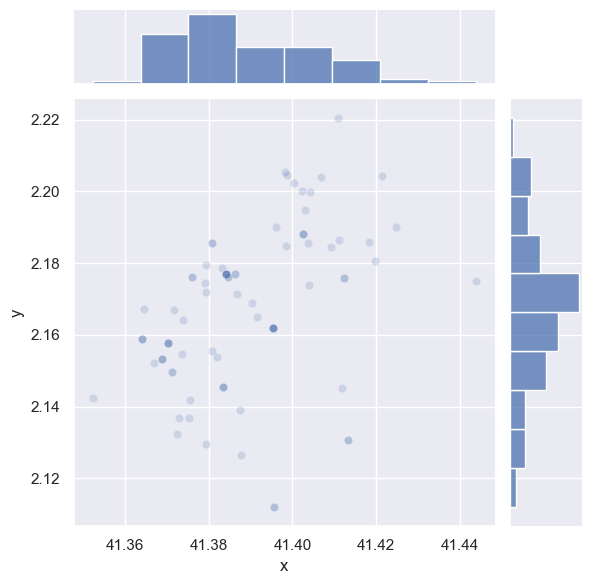

In [66]:
sns.jointplot(x="x", y="y", data=events_df, alpha=0.2)

In [67]:
std_dev_x, std_dev_y = events_df.x.std(), events_df.y.std()

In [68]:
# Filter df by the dates that we have
df_common_events = pd.concat(
    [
        pd.merge(df, events_df, left_on='date', right_on='start_date'), 
        pd.merge(df, events_df, left_on='date', right_on='end_date')
    ],
    axis=0
).drop_duplicates()

In [69]:
print(df_common_events.shape)
df_common_events.head()

(814524, 59)


,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,covid_cases,confinment,start_date,end_date,x,y
0,1,2020,6,17,0,24.500000,24.416667,0.083333,18.583333,1.0,1.0,1.0,1.592347e+09,1.0,1.0,1.592347e+09,9.083333,2020-06-17 00:00:00,2020-06-17,0.431335,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894
1,1,2020,6,17,1,28.500000,28.250000,0.250000,14.750000,1.0,1.0,1.0,1.592350e+09,1.0,1.0,1.592350e+09,17.750000,2020-06-17 01:00:00,2020-06-17,0.341040,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894
2,1,2020,6,17,2,28.916667,28.833333,0.083333,15.166667,1.0,1.0,1.0,1.592354e+09,1.0,1.0,1.592354e+09,20.250000,2020-06-17 02:00:00,2020-06-17,0.344045,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894
3,1,2020,6,17,3,29.000000,29.000000,0.000000,15.083333,1.0,1.0,1.0,1.592357e+09,1.0,1.0,1.592358e+09,15.916667,2020-06-17 03:00:00,2020-06-17,0.342155,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894
4,1,2020,6,17,4,29.000000,29.000000,0.000000,17.000000,1.0,1.0,1.0,1.592361e+09,1.0,1.0,1.592361e+09,14.250000,2020-06-17 04:00:00,2020-06-17,0.369565,0.0,41.397978,2.180107,16.0,46.0,2020-06-17,25.3,15.7,19.9,25.3,15.7,19.9,15.6,76.7,0.037,100.0,12.5,0.0,0.0,26.5,21.3,237.3,1015.3,27.0,18.3,277.5,23.9,9.0,1.592367e+09,1.592422e+09,"Rain, Partially cloudy",rain,NaN,15.0,0,2020-06-17,2020-06-17,41.404153,2.199894


In [70]:
df_common_events.date

0         2020-06-17
1         2020-06-17
2         2020-06-17
3         2020-06-17
4         2020-06-17
             ...    
925424    2020-09-30
925425    2020-09-30
925426    2020-09-30
925427    2020-09-30
925428    2020-09-30
Name: date, Length: 814524, dtype: object

In [71]:
df_common_events.year.unique()

array([2020, 2019, 2021, 2023, 2022], dtype=int32)

In [72]:
with tqdm(total=len(events_df)) as pbar:
    for idx, row in events_df.iterrows():    
        # Filter by the range of the dates
        x, y = row.x, row.y
        start_date, end_date = row['start_date'], row['end_date']
        range_dates = pd.date_range(start_date, end_date)
        range_df = df_common_events[df_common_events.date.isin([range_date.date() for range_date in range_dates])]
        
        if len(range_df) > 0:
            # Near position of the event with relation of the biking center (30% of standard deviations of x & y)
            range_df = range_df[(range_df.lat > x - std_dev_x * 0.3) & (range_df.lat < x + std_dev_x * 0.3)]
            range_df = range_df[(range_df.lat > y - std_dev_y * 0.3) & (range_df.lat < y + std_dev_y * 0.3)]
            df.loc[range_df.index, 'has_event'] = 1

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:01<00:00, 71.24it/s]


In [73]:
df.has_event = df.has_event.fillna(0)

### Public Holidays

In [4]:
e = open('calendarifestius_en.ics', 'rb')
ecal = icalendar.Calendar.from_ical(e.read())
for component in ecal.walk():
    print(component.name)
e.close()

VCALENDAR
VTIMEZONE
DAYLIGHT
STANDARD
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT


In [5]:
def get_cal_events(ecal):
    # Extract relevant information
    events = []
    for event in ecal.walk('VEVENT'):
        event_data = {
            'Summary': event.get('summary'),
            'Start': event.get('dtstart').dt,
            'End': event.get('dtend').dt,
            # Add more properties as needed
        }
        events.append(event_data)

    # Create a DataFrame from the extracted information
    return pd.DataFrame(events)

In [6]:
df_ecal = get_cal_events(ecal)

# Print the DataFrame
print(df_ecal.dtypes)

Summary    object
Start      object
End        object
dtype: object


In [7]:
df_ecal['Start'] = pd.to_datetime(df_ecal['Start'], utc=True).dt.date
df_ecal['End'] = pd.to_datetime(df_ecal['End'], utc=True).dt.date
df_ecal.head()

,Summary,Start,End
0,Epiphany / Three Kings’ Day,2023-01-06,2023-01-07
1,Good Friday,2023-04-07,2023-04-08
2,Easter Monday,2023-04-10,2023-04-11
3,Labour Day,2023-05-01,2023-05-02
4,Local holidays in Barcelona,2023-06-05,2023-06-06


In [8]:
df_ecal = df_ecal.rename(columns={
    "Start": 'start_date', 
    "End": 'end_date', 
    "Summary":"name"
})
df_ecal.head()

,name,start_date,end_date
0,Epiphany / Three Kings’ Day,2023-01-06,2023-01-07
1,Good Friday,2023-04-07,2023-04-08
2,Easter Monday,2023-04-10,2023-04-11
3,Labour Day,2023-05-01,2023-05-02
4,Local holidays in Barcelona,2023-06-05,2023-06-06


In [79]:
with tqdm(total=len(df_ecal)) as pbar:
    for idx, row in df_ecal.iterrows():    
        start_date, end_date = row['start_date'], row['end_date']
        
        for year in YEARS:
            holiday_start_date = date(year, start_date.month, start_date.day)
            holiday_end_date = date(year, end_date.month, end_date.day)
            range_dates = pd.date_range(holiday_start_date, holiday_end_date)
            range_df = df[df.date.isin([range_date.date() for range_date in range_dates])]
            
            if len(range_df) > 0:
                df.loc[range_df.index, 'has_holiday'] = 1

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


In [80]:
# Check some dates
df[df.has_holiday.notnull()].head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,covid_cases,confinment,has_event,has_holiday
95,1,2020,6,5,0,16.583333,16.583333,0.000000,28.416667,1.0,1.0,1.0,1.591310e+09,1.0,1.0,1.591310e+09,18.166667,2020-06-05 00:00:00,2020-06-05,0.631481,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0
96,1,2020,6,5,1,16.000000,16.000000,0.000000,29.000000,1.0,1.0,1.0,1.591313e+09,1.0,1.0,1.591314e+09,14.000000,2020-06-05 01:00:00,2020-06-05,0.644444,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0
97,1,2020,6,5,2,16.250000,16.250000,0.000000,28.750000,1.0,1.0,1.0,1.591317e+09,1.0,1.0,1.591317e+09,17.833333,2020-06-05 02:00:00,2020-06-05,0.638889,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0
98,1,2020,6,5,3,17.166667,17.000000,0.166667,28.000000,1.0,1.0,1.0,1.591321e+09,1.0,1.0,1.591321e+09,16.666667,2020-06-05 03:00:00,2020-06-05,0.619926,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0
99,1,2020,6,5,4,17.583333,17.000000,0.583333,28.416667,1.0,1.0,1.0,1.591324e+09,1.0,1.0,1.591324e+09,13.000000,2020-06-05 04:00:00,2020-06-05,0.617754,0.0,41.397978,2.180107,16.0,46.0,2020-06-05,25.3,15.2,19.3,25.3,15.2,19.3,13.4,69.3,0.0,0.0,0.0,0.0,0.0,28.1,25.1,213.5,1008.5,31.0,17.9,308.1,26.6,9.0,1.591331e+09,1.591385e+09,Partially cloudy,partly-cloudy-day,NaN,42.0,0,0.0,1.0


In [81]:
df['has_holiday'] = df['has_holiday'].fillna(0)
df['has_holiday'] = df['has_holiday'].astype('int')

In [82]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,covid_cases,confinment,has_event,has_holiday
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.824380,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.816434,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.823864,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0


### Traffic

In [83]:
os.makedirs('./traffic', exist_ok=True)

In [84]:
TRAFFIC_BASE_URL = "https://opendata-ajuntament.barcelona.cat/data/en/dataset/trams"

In [ ]:
if not os.listdir('./traffic'):
    print('here')
    response = requests.get(TRAFFIC_BASE_URL)
    
    soup = BeautifulSoup(response.content)
    resource_items = soup.find_all("li", {"class": "resource-item"})
    
    for resource_item in resource_items[1:]:
        file_name: str = resource_item.find('a').text[:-4]
        anchor_download_path = resource_item.find('a', href=re.compile(r'^https://opendata-ajuntament.barcelona.cat/data/dataset/*'))
        url_download_path = anchor_download_path['href']

        os.system(f"wget '{url_download_path}'")
        os.system(f"mv 'download' './traffic/{file_name.replace('\n', '').strip()}'")

In [87]:
traffic_df = pd.DataFrame()

In [88]:
for csv in tqdm(os.listdir('./traffic')):
    year, month, *_ = csv.split('_')
    year, month = int(year), int(month)
    
    if year not in YEARS:
        continue
        
    new_traffic_df = pd.read_csv('./traffic/' + csv, on_bad_lines='skip')
    new_traffic_df['date'] = pd.to_datetime(
        new_traffic_df['data'], format='%Y%m%d%H%M%S'
    )
    new_traffic_df = new_traffic_df.drop(['data'], axis=1)
    
    new_traffic_df['year'] = new_traffic_df['date'].dt.year
    new_traffic_df['month'] = new_traffic_df['date'].dt.month
    new_traffic_df['day'] = new_traffic_df['date'].dt.day
    new_traffic_df['hour'] = new_traffic_df['date'].dt.hour
    
    new_traffic_df = new_traffic_df.groupby(
        [
            # 'idTram', --> have not the mapping to the zone
            'year', 
            'month', 
            'day', 
            'hour'
        ])\
        .mean(numeric_only=True)\
        .reset_index()\
        .drop(['idTram'], axis=1)
    
    traffic_df = pd.concat(
        [traffic_df, new_traffic_df], 
        axis=0
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:54<00:00,  1.28it/s]


In [89]:
df = pd.merge(
    df,
    traffic_df,
    how='left',
    left_on=('year', 'month', 'day', 'hour'),
    right_on=('year', 'month', 'day', 'hour')
)

In [90]:
df.to_csv(
    'df.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

In [149]:
df = pd.read_csv(
    'df.csv.gz', 
    compression='gzip'
)

/var/folders/_m/3xk3lkv56h1ft3h425mswtn80000gn/T/ipykernel_60902/2348401915.py:1: DtypeWarning: Columns (25,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df.csv.gz',


### Selected Columns

In [150]:
df.head()

,station_id,year,month,day,hour,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl,date_time,date,percentage_docks_available,traffic,lat,lon,altitude,capacity,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,snow,snowdepth,windgust,windspeed,winddir,pressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,sunriseEpoch,sunsetEpoch,conditions,icon,severerisk,covid_cases,confinment,has_event,has_holiday,estatActual,estatPrevist
0,1,2020,6,1,0,7.727273,7.727273,0.0,36.272727,1.0,1.0,1.0,1.590964e+09,1.0,1.0,1.590964e+09,17.363636,2020-06-01 00:00:00,2020-06-01,0.824380,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.140101
1,1,2020,6,1,1,8.076923,8.076923,0.0,35.923077,1.0,1.0,1.0,1.590968e+09,1.0,1.0,1.590968e+09,15.461538,2020-06-01 01:00:00,2020-06-01,0.816434,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.104522
2,1,2020,6,1,2,7.750000,7.750000,0.0,36.250000,1.0,1.0,1.0,1.590971e+09,1.0,1.0,1.590972e+09,14.083333,2020-06-01 02:00:00,2020-06-01,0.823864,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.096932
3,1,2020,6,1,3,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590975e+09,1.0,1.0,1.590975e+09,14.250000,2020-06-01 03:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.099304
4,1,2020,6,1,4,8.000000,8.000000,0.0,36.000000,1.0,1.0,1.0,1.590979e+09,1.0,1.0,1.590979e+09,19.250000,2020-06-01 04:00:00,2020-06-01,0.818182,0.0,41.397978,2.180107,16.0,46.0,2020-06-01,25.3,18.1,21.5,25.3,18.1,21.5,17.6,78.5,0.196,100.0,8.33,0.0,0.0,18.2,15.2,169.9,1015.5,37.6,17.5,182.8,15.7,8.0,1.590985e+09,1.591039e+09,"Rain, Partially cloudy",rain,NaN,4.0,0,0.0,0,0.0,0.098830


In [151]:
df.columns.values

array(['station_id', 'year', 'month', 'day', 'hour',
       'num_bikes_available', 'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'last_reported',
       'is_charging_station', 'status', 'last_updated', 'ttl',
       'date_time', 'date', 'percentage_docks_available', 'traffic',
       'lat', 'lon', 'altitude', 'capacity', 'datetime', 'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike',
       'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'pressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy',
       'uvindex', 'sunriseEpoch', 'sunsetEpoch', 'conditions', 'icon',
       'severerisk', 'covid_cases', 'confinment', 'has_event',
       'has_holiday', 'estatActual', 'estatPrevist'], dtype=object)

Once we have extended our dataframe with external sources, we are going to make the selection of the columns that we want.

In [152]:
selected_columns_df = [
    'station_id', 
    # 'num_bikes_available', 'num_bikes_available_types.mechanical',                          # unnecessary docks info
    # 'num_bikes_available_types.ebike', 'num_docks_available', 
    'percentage_docks_available',                                                             # docks info
    # 'status', 
    'lat', 'lon', 'altitude', 'capacity',                                                     # station info
    'year', 'month', 'day', 'hour', 'date_time', 'date',                                      # time info
    'covid_cases', 'confinment', 'has_holiday', # 'has_event' -> incomplete                   # context info
    'temp', 'feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'uvindex', 'visibility',  # meteorological info
    'estatActual', 'traffic'
]

selected_df = df[selected_columns_df]

In [94]:
# Checkpoint of the extended df with external sources
selected_df.to_csv(
    'df_selected.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

In [3]:
selected_df = pd.read_csv(
    'df_selected.csv.gz', 
    compression='gzip'
)

## Data Engineering

Engineer new variables from the information that we already have. 

In [4]:
selected_df.date_time = pd.to_datetime(selected_df.date_time)

### Time

In [5]:
# Would need to get the dummies for them
date_time_fields = ['day_info', 'hour_info', 'month_info']

Related to the **day** (weekend).

In [207]:
def get_day_info(date_time):
    return 'weekend' if date_time.weekday() in [5, 6] else 'weekday'

In [7]:
selected_df['day_info'] = selected_df.date_time.apply(lambda x: get_day_info(x))

Related to the **hour** (which time of day it was).

In [208]:
def get_hour_info(date_time):
    if date_time.hour in range(5):
        return 'late_night'

    elif date_time.hour in range(5, 9):
        return 'early_morning'

    elif date_time.hour in range(9, 13):
        return 'morning'
    
    elif date_time.hour in range(13, 17):
        return 'noon'
    
    elif date_time.hour in range(17, 21):
        return 'eve'
    
    return 'night'

In [9]:
selected_df['hour_info'] = selected_df.date_time.apply(lambda x: get_hour_info(x))

Related to the **month** (season).

In [209]:
def get_month_info(date):
    if date.month in (3, 4, 5):
        return 'spring'
    
    elif date.month in (6, 7, 8):
        return 'summer'
    
    elif date.month in (9, 10, 11):
        return 'autumn'
    
    return 'winter'

In [11]:
selected_df['month_info'] = selected_df.date_time.apply(lambda x: get_month_info(x))

In [12]:
selected_df.head()

,station_id,percentage_docks_available,lat,lon,altitude,capacity,year,month,day,hour,date_time,date,covid_cases,confinment,has_holiday,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,estatActual,traffic,day_info,hour_info,month_info
0,1,0.824380,41.397978,2.180107,16.0,46.0,2020,6,1,0,2020-06-01 00:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer
1,1,0.816434,41.397978,2.180107,16.0,46.0,2020,6,1,1,2020-06-01 01:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer
2,1,0.823864,41.397978,2.180107,16.0,46.0,2020,6,1,2,2020-06-01 02:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer
3,1,0.818182,41.397978,2.180107,16.0,46.0,2020,6,1,3,2020-06-01 03:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer
4,1,0.818182,41.397978,2.180107,16.0,46.0,2020,6,1,4,2020-06-01 04:00:00,2020-06-01,4.0,0,0,21.5,21.5,78.5,0.196,0.0,15.2,8.0,17.5,0.0,0.0,weekday,late_night,summer


### Data Shifting

We need to create a shift of the availability in the previous availabilities.

In [13]:
selected_df = selected_df.sort_values(['station_id', 'date_time'], ascending=True)

In [14]:
df_shifted = pd.DataFrame()

In [15]:
def create_moving_average(row):
    return (row['ctx-4'] * 4 + row['ctx-3'] * 3 + row['ctx-2'] * 2 + row['ctx-1']) / 10

In [ ]:
for station_id in tqdm(selected_df.station_id.unique()):
    station_df = selected_df[selected_df.station_id == station_id]
    station_df['ctx-4'] = station_df.percentage_docks_available.shift(4)
    station_df['ctx-3'] = station_df.percentage_docks_available.shift(3)
    station_df['ctx-2'] = station_df.percentage_docks_available.shift(2)
    station_df['ctx-1'] = station_df.percentage_docks_available.shift(1)
    
    # Handle NaN
    station_df['ctx-4'] = station_df['ctx-4'].fillna(station_df['percentage_docks_available'])
    station_df['ctx-3'] = station_df['ctx-3'].fillna(station_df['percentage_docks_available'])
    station_df['ctx-2'] = station_df['ctx-2'].fillna(station_df['percentage_docks_available'])
    station_df['ctx-1'] = station_df['ctx-1'].fillna(station_df['percentage_docks_available'])
    
    station_df['ctx-ma'] = station_df.apply(lambda x: create_moving_average(x), axis=1)
    
    df_shifted = pd.concat([station_df, df_shifted], axis=0)
    

In [18]:
df_shifted.to_csv('./df_shifted_checkpoint.csv', index=False, header=True)

In [9]:
df_shifted = pd.read_csv('./df_shifted_checkpoint.csv')

### Train / Val / Test Split

In [126]:
df_shifted.head()

,station_id,percentage_docks_available,lat,lon,altitude,capacity,year,month,day,hour,date_time,date,covid_cases,confinment,has_holiday,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,estatActual,traffic,day_info,hour_info,month_info,ctx-4,ctx-3,ctx-2,ctx-1,ctx-ma
0,532,0.333333,NaN,NaN,NaN,NaN,2022,11,11,10,2022-11-11 10:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.280702,0.0,weekday,morning,autumn,0.333333,0.333333,0.333333,0.333333,0.333333
1,532,0.000000,NaN,NaN,NaN,NaN,2022,11,11,11,2022-11-11 11:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.643014,0.0,weekday,morning,autumn,0.000000,0.000000,0.000000,0.333333,0.033333
2,532,0.000000,NaN,NaN,NaN,NaN,2022,11,11,12,2022-11-11 12:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.690946,0.0,weekday,morning,autumn,0.000000,0.000000,0.333333,0.000000,0.066667
3,532,0.000000,NaN,NaN,NaN,NaN,2022,11,11,13,2022-11-11 13:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.712876,0.0,weekday,noon,autumn,0.000000,0.333333,0.000000,0.000000,0.100000
4,532,0.000000,NaN,NaN,NaN,NaN,2022,11,11,14,2022-11-11 14:00:00,2022-11-11,5.0,0,0,17.2,17.2,77.7,0.0,0.0,26.6,4.0,15.5,1.737312,0.0,weekday,noon,autumn,0.333333,0.000000,0.000000,0.000000,0.133333


In [127]:
train_df = df_shifted[df_shifted.year != 2023]
test_df = df_shifted[df_shifted.year == 2023]

In [128]:
print('Train size: ', train_df.shape[0])
print('Test size: ', test_df.shape[0])

Train size:  13404710
Test size:  1693864


In [129]:
valid_df = test_df[test_df.month <= 3]
test_df = test_df[test_df.month > 3]

## Data Exploration

In [130]:
# Exploring a sample of the train data might be enough to already get some insights
train_df_sampled = train_df.sample(frac=.01)

### Time Variables

In [131]:
train_df_sampled\
    .groupby('hour_info')['percentage_docks_available']\
    .mean()\
    .sort_values(ascending=False)

hour_info
eve              0.650122
noon             0.634081
morning          0.625804
night            0.618424
early_morning    0.605982
late_night       0.592331
Name: percentage_docks_available, dtype: float64

### Traffic Variables

Variation of the traffic during the day.

<Axes: xlabel='hour'>

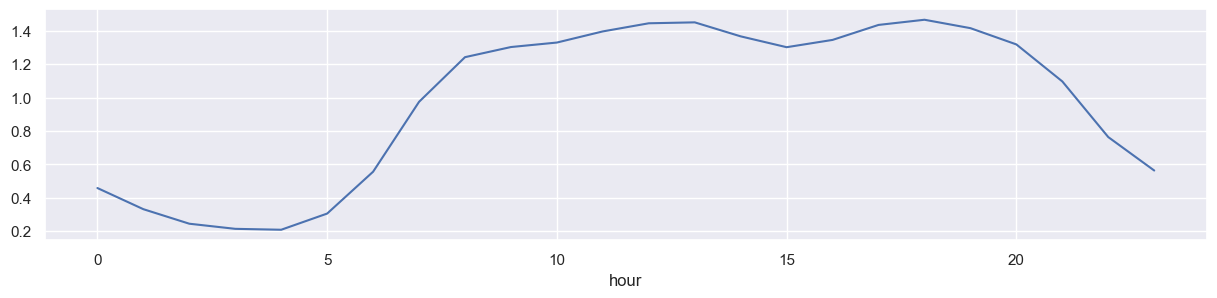

In [132]:
train_df_sampled.groupby('hour')['estatActual'].mean().plot()

In [133]:
# We can see a linear correlation of around 10% between the amount of traffic and % docks available
train_df_sampled[['percentage_docks_available', 'estatActual']].corr()

,percentage_docks_available,estatActual
percentage_docks_available,1.000000,0.090455
estatActual,0.090455,1.000000


## Handling Nulls

In [134]:
train_df.isnull().sum(axis=0)

station_id                         0
percentage_docks_available      5177
lat                            43703
lon                            43703
altitude                       43703
capacity                       43703
year                               0
month                              0
day                                0
hour                               0
date_time                          0
date                               0
covid_cases                        0
confinment                         0
has_holiday                        0
temp                               0
feelslike                          0
humidity                           0
precip                             0
snow                               0
windspeed                          0
uvindex                            0
visibility                         0
estatActual                   237587
traffic                            0
day_info                           0
hour_info                          0
m

For the percentage of docks available, we will assume it is 0

In [135]:
# percentage_docks_available is null if we divided 0 / 0
train_df[train_df['percentage_docks_available'].isnull()].head()

,station_id,percentage_docks_available,lat,lon,altitude,capacity,year,month,day,hour,date_time,date,covid_cases,confinment,has_holiday,temp,feelslike,humidity,precip,snow,windspeed,uvindex,visibility,estatActual,traffic,day_info,hour_info,month_info,ctx-4,ctx-3,ctx-2,ctx-1,ctx-ma
20263,519,NaN,41.424655,2.166289,110.0,24.0,2022,12,9,13,2022-12-09 13:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.614818,0.0,weekday,noon,winter,0.809028,0.840278,0.868056,0.848485,0.834154
20264,519,NaN,41.424655,2.166289,110.0,24.0,2022,12,9,14,2022-12-09 14:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.520207,0.0,weekday,noon,winter,0.840278,0.868056,0.848485,NaN,NaN
20265,519,NaN,41.424655,2.166289,110.0,24.0,2022,12,9,15,2022-12-09 15:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.453634,0.0,weekday,noon,winter,0.868056,0.848485,NaN,NaN,NaN
20266,519,NaN,41.424655,2.166289,110.0,24.0,2022,12,9,16,2022-12-09 16:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.496084,0.0,weekday,noon,winter,0.848485,NaN,NaN,NaN,NaN
20267,519,NaN,41.424655,2.166289,110.0,24.0,2022,12,9,17,2022-12-09 17:00:00,2022-12-09,5.0,0,1,13.9,13.9,80.5,13.472,0.0,21.0,4.0,12.0,1.567513,0.0,weekday,eve,winter,NaN,NaN,NaN,NaN,NaN


In [136]:
train_df['percentage_docks_available'] = train_df['percentage_docks_available'].fillna(.0)
valid_df['percentage_docks_available'] = valid_df['percentage_docks_available'].fillna(.0)
test_df['percentage_docks_available'] = test_df['percentage_docks_available'].fillna(.0)

For the context that are nulls, we will assume it is their actual one.

For the station information, we will put the **mean**.

In [137]:
# Lat, Long, Altittude & Capacity: some stations have missing information
train_df[train_df['lat'].isnull()].station_id.unique()

array([532, 530, 529, 520, 415,  93,  59])

In [138]:
STATION_INFO = ['lat', 'lon', 'altitude', 'capacity']

In [139]:
station_info_imputer = SimpleImputer(strategy='mean')
station_info_imputer.fit(train_df[STATION_INFO])

SimpleImputer()

In [140]:
def input_missing_with_imputer(df: pd.DataFrame, imputer: SimpleImputer = station_info_imputer, columns: typing.List[str] = STATION_INFO):
    df_null = df[df[columns[0]].isnull()]
    
    if df_null.empty:
        return df
    
    df_null_values = imputer.transform(df_null[columns])
    df.loc[df_null.index, columns] = df_null_values
    
    return df

In [141]:
train_df = input_missing_with_imputer(train_df)
valid_df = input_missing_with_imputer(valid_df)
test_df = input_missing_with_imputer(test_df)

For the traffic actual state, we will also use a simple imputer.

In [142]:
traffic_info_imputer = SimpleImputer(strategy='mean')
traffic_info_imputer.fit(train_df['estatActual'].values.reshape(-1, 1))

SimpleImputer()

In [143]:
train_df = input_missing_with_imputer(train_df, traffic_info_imputer, ['estatActual'])
valid_df = input_missing_with_imputer(valid_df, traffic_info_imputer, ['estatActual'])
test_df = input_missing_with_imputer(test_df, traffic_info_imputer, ['estatActual'])

In [144]:
train_df['ctx-4'] = train_df['ctx-4'].fillna(train_df['percentage_docks_available'])
train_df['ctx-3'] = train_df['ctx-3'].fillna(train_df['percentage_docks_available'])
train_df['ctx-2'] = train_df['ctx-2'].fillna(train_df['percentage_docks_available'])
train_df['ctx-1'] = train_df['ctx-1'].fillna(train_df['percentage_docks_available'])
train_df['ctx-ma'] = train_df['ctx-ma'].fillna(train_df['percentage_docks_available'])

valid_df['ctx-4'] = valid_df['ctx-4'].fillna(valid_df['percentage_docks_available'])
valid_df['ctx-3'] = valid_df['ctx-3'].fillna(valid_df['percentage_docks_available'])
valid_df['ctx-2'] = valid_df['ctx-2'].fillna(valid_df['percentage_docks_available'])
valid_df['ctx-1'] = valid_df['ctx-1'].fillna(valid_df['percentage_docks_available'])
valid_df['ctx-ma'] = valid_df['ctx-ma'].fillna(valid_df['percentage_docks_available'])

test_df['ctx-4'] = test_df['ctx-4'].fillna(test_df['percentage_docks_available'])
test_df['ctx-3'] = test_df['ctx-3'].fillna(test_df['percentage_docks_available'])
test_df['ctx-2'] = test_df['ctx-2'].fillna(test_df['percentage_docks_available'])
test_df['ctx-1'] = test_df['ctx-1'].fillna(test_df['percentage_docks_available'])
test_df['ctx-ma'] = test_df['ctx-ma'].fillna(test_df['percentage_docks_available'])

In [145]:
train_df.isnull().sum()

station_id                    0
percentage_docks_available    0
lat                           0
lon                           0
altitude                      0
capacity                      0
year                          0
month                         0
day                           0
hour                          0
date_time                     0
date                          0
covid_cases                   0
confinment                    0
has_holiday                   0
temp                          0
feelslike                     0
humidity                      0
precip                        0
snow                          0
windspeed                     0
uvindex                       0
visibility                    0
estatActual                   0
traffic                       0
day_info                      0
hour_info                     0
month_info                    0
ctx-4                         0
ctx-3                         0
ctx-2                         0
ctx-1   

# Features

Based on the station_id, we are going to get:
- capacity
- status
- altitude

And some will not be used:
- _lat/lon_: will not be used

We will not use the station_id feature per se, as it is too specific and might lead to overfitting.

--------------------------------

On the time, we will already be given:
- month
- day
- hour
- has_holiday: will know if is a holiday
- day_info / hour_info / month_info: with the functions created
- feelslike / humidity / precip / snow / windspeed / uvindex / visibility / 
- confinment: most likely 0
- covid_case: input the percentile

--------------------------------

And for other time variables, we will not use them:
- _year_
- _date_
- _date_time_

## Handling Categoric

### Clustering

We could group the bicying stations by clusters, as some of them might have greater or lower usage.

Then, based on the **station_id**, we could know to which cluster it is refering.

Afterwards, with those same groups we could see if some of them given the predicted percentage could be given more capacity or stations.

In [146]:
COORDINATES_INFO = ['lat', 'lon']

X_cluster_coordinates = train_df[['station_id', 'altitude', 'capacity', *COORDINATES_INFO]]\
    .drop_duplicates()\
    .reset_index(drop=True)

In [147]:
kmeans_coordinates = KMeans(n_clusters=15, init='k-means++')

In [148]:
coordinates_scaler = MinMaxScaler()
X_cluster_coordinates[COORDINATES_INFO] = coordinates_scaler.fit_transform(X_cluster_coordinates[COORDINATES_INFO])

In [149]:
X_cluster_coordinates['cluster_label'] = kmeans_coordinates.fit_predict(X_cluster_coordinates)

<Axes: xlabel='lat', ylabel='lon'>

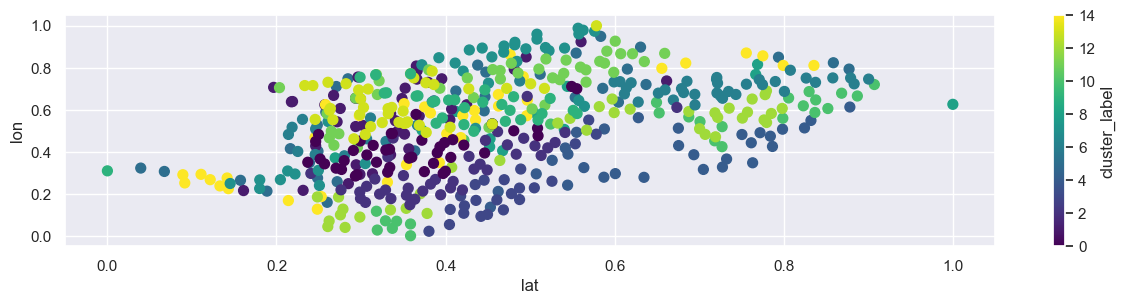

In [150]:
X_cluster_coordinates.plot.scatter(x='lat', y='lon', c='cluster_label', s=50, cmap='viridis')

In [151]:
cluster_df = X_cluster_coordinates # .drop(COORDINATES_INFO, axis=1)  --> will keep it, and discarded in FS
cluster_df # for adding this info, will do a merge

,station_id,altitude,capacity,lat,lon,cluster_label
0,532,34.195957,26.950944,0.455289,0.532018,8
1,530,34.195957,26.950944,0.455289,0.532018,8
2,529,34.195957,26.950944,0.455289,0.532018,8
3,520,34.195957,26.950944,0.455289,0.532018,8
4,519,110.000000,24.000000,0.675338,0.512252,4
...,...,...,...,...,...,...
511,5,7.000000,39.000000,0.384398,0.636760,9
512,4,8.000000,21.000000,0.403595,0.646371,9
513,3,11.000000,27.000000,0.410865,0.647108,9
514,2,17.000000,29.000000,0.422415,0.610062,9


In [115]:
# We no longer need lat and lon
# train_df = train_df.drop(COORDINATES_INFO, axis=1)
# valid_df = valid_df.drop(COORDINATES_INFO, axis=1)
# test_df = test_df.drop(COORDINATES_INFO, axis=1)

### Dummyfication

In [152]:
CATEGORICAL_COLUMNS = ['day_info', 'hour_info', 'month_info']

In [153]:
train_df[CATEGORICAL_COLUMNS].dtypes

day_info      object
hour_info     object
month_info    object
dtype: object

In [154]:
categorical_label_encoder = OneHotEncoder()
categorical_train_encoding = categorical_label_encoder.fit_transform(train_df[CATEGORICAL_COLUMNS])

In [155]:
CATEGORICAL_FEATURES = [
    val for sublist in 
    [arr.tolist() for arr in categorical_label_encoder.categories_]
    for val in sublist
]
CATEGORICAL_FEATURES

['weekday',
 'weekend',
 'early_morning',
 'eve',
 'late_night',
 'morning',
 'night',
 'noon',
 'autumn',
 'spring',
 'summer',
 'winter']

In [156]:
train_df[CATEGORICAL_FEATURES] = categorical_train_encoding.toarray()

In [157]:
valid_df[CATEGORICAL_FEATURES] = categorical_label_encoder.transform(valid_df[CATEGORICAL_COLUMNS]).toarray()
test_df[CATEGORICAL_FEATURES] = categorical_label_encoder.transform(test_df[CATEGORICAL_COLUMNS]).toarray()

In [158]:
# And drop unwanted
train_df.drop(CATEGORICAL_COLUMNS, axis=1, inplace=True)
valid_df.drop(CATEGORICAL_COLUMNS, axis=1, inplace=True)
test_df.drop(CATEGORICAL_COLUMNS, axis=1, inplace=True)

In [159]:
CATEGORICAL_FEATURES_DEFINITIVE = CATEGORICAL_FEATURES + ['confinment', 'has_holiday'] 

## Handling Numeric Data

In [160]:
# Remove some unwanted columns
train_df.drop(['date_time', 'date'], axis=1, inplace=True)
valid_df.drop(['date_time', 'date'], axis=1, inplace=True)
test_df.drop(['date_time', 'date'], axis=1, inplace=True)

In [161]:
month_unique = train_df.month.unique()
hour_unique = train_df.hour.unique()
day_unique = train_df.day.unique()

NUMERICAL_FEATURES_TO_COMPUTE = [
    'temp',
    'feelslike',
    'humidity',
    'precip',
    'snow',
    'windspeed',
    'uvindex',
    'visibility',
    'estatActual',
    'traffic',
]

Will get the means of those additiona numerical information based on the month, day and hour.

In [166]:
df_numerical_features = pd.DataFrame()

In [167]:
# For all of them, we will compute the mean
with tqdm(total=len(month_unique) * len(day_unique) * len(hour_unique)) as pbar:
    for month in month_unique:
        for day in day_unique:
            for hour in hour_unique:
                df_numerical_features_to_compute = train_df.loc[
                    # (train_df.station_id == station_id) &
                    (train_df.month == month) &
                    (train_df.day == day) &
                    (train_df.hour == hour), 
                    NUMERICAL_FEATURES_TO_COMPUTE
                ].mean()

                df_numerical_features.loc[
                    len(df_numerical_features),
                    [
                        'month',
                        'day',
                        'hour',
                        *NUMERICAL_FEATURES_TO_COMPUTE
                    ] 
                ] = [month, day, hour, *df_numerical_features_to_compute.values]

                pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8928/8928 [03:14<00:00, 45.84it/s]


In [168]:
numeric_imputer = SimpleImputer()

In [169]:
numeric_imputer.fit(df_numerical_features[NUMERICAL_FEATURES_TO_COMPUTE])

SimpleImputer()

In [170]:
numerical_features_null = df_numerical_features[
    df_numerical_features.isnull().any(axis=1)
][NUMERICAL_FEATURES_TO_COMPUTE]

In [171]:
df_numerical_features.loc[
    numerical_features_null.index.values, 
    NUMERICAL_FEATURES_TO_COMPUTE
] = numeric_imputer.transform(numerical_features_null)

In [172]:
df_numerical_features.isnull().sum(axis=0)

month          0
day            0
hour           0
temp           0
feelslike      0
humidity       0
precip         0
snow           0
windspeed      0
uvindex        0
visibility     0
estatActual    0
traffic        0
dtype: int64

In [173]:
# Get rid of actual numerical values
train_df.drop(NUMERICAL_FEATURES_TO_COMPUTE, axis=1, inplace=True)
valid_df.drop(NUMERICAL_FEATURES_TO_COMPUTE, axis=1, inplace=True)
test_df.drop(NUMERICAL_FEATURES_TO_COMPUTE, axis=1, inplace=True)

In [174]:
train_df = pd.merge(train_df, df_numerical_features, left_on=('month', 'day', 'hour'), right_on=('month', 'day', 'hour'))

In [175]:
valid_df = pd.merge(valid_df, df_numerical_features, left_on=('month', 'day', 'hour'), right_on=('month', 'day', 'hour'))

In [176]:
test_df = pd.merge(test_df, df_numerical_features, left_on=('month', 'day', 'hour'), right_on=('month', 'day', 'hour'))

In [179]:
NUMERICAL_FEATURES = [
    'altitude', 
    'capacity',
    'month', 
    'day', 
    'hour', 
    'covid_cases', 
    'temp', 
    'feelslike',
    'humidity', 
    'precip', 
    'snow', 
    'windspeed', 
    'uvindex', 
    'visibility',
    'estatActual', 
    'traffic', 
    'ctx-4', 
    'ctx-3', 
    'ctx-2', 
    'ctx-1',
    'ctx-ma',
    'lat',
    'lon'
]

In [180]:
numeric_scaler = MinMaxScaler().fit(train_df[NUMERICAL_FEATURES])

In [181]:
train_df[NUMERICAL_FEATURES] = numeric_scaler.transform(train_df[NUMERICAL_FEATURES])
valid_df[NUMERICAL_FEATURES] = numeric_scaler.transform(valid_df[NUMERICAL_FEATURES])
test_df[NUMERICAL_FEATURES] = numeric_scaler.transform(test_df[NUMERICAL_FEATURES])

In [182]:
# Some final values we need to drop
train_df.drop(['year'], axis=1, inplace=True)
valid_df.drop(['year'], axis=1, inplace=True)
test_df.drop(['year'], axis=1, inplace=True)

# Train

In [183]:
train_df.to_csv('train.csv', index=False, header=True)
valid_df.to_csv('valid.csv', index=False, header=True)
test_df.to_csv('test.csv', index=False, header=True)

In [69]:
# train_df.to_csv('train.csv', index=False, header=True)
# valid_df.to_csv('valid.csv', index=False, header=True)
# test_df.to_csv('test.csv', index=False, header=True)

# train_df = pd.read_csv('train.csv')
# valid_df = pd.read_csv('valid.csv')
# test_df = pd.read_csv('test.csv')

In [184]:
FEATURES = [*CATEGORICAL_FEATURES_DEFINITIVE, *NUMERICAL_FEATURES]

In [185]:
X_train = train_df[FEATURES]
Y_train = [val if val > 0 else 0 for val in train_df['percentage_docks_available']]
Y_train = np.array([val if val < 1 else 1 for val in Y_train])

In [186]:
X_valid = valid_df[FEATURES]
Y_valid = [val if val > 0 else 0 for val in valid_df['percentage_docks_available']]
Y_valid = np.array([val if val < 1 else 1 for val in Y_valid])

In [187]:
X_test = test_df[FEATURES]
Y_test = [val if val > 0 else 0 for val in test_df['percentage_docks_available']]
Y_test = np.array([val if val < 1 else 1 for val in Y_test])

## Feature Selection

In [188]:
from numpy import sort

In [189]:
xgb_model = xgb.XGBRFRegressor(
    objective='reg:logistic', 
    eval_metric='rmse', 
) # , n_estimators=200, max_depth=5)

In [190]:
xgb_model.fit(X_train, Y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='rmse', feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:logistic', predictor=None, random_state=None,
               reg_alpha=None, ...)

In [191]:
mean_squared_error(Y_train, xgb_model.predict(X_train), squared=False)

0.12483305615528895

In [192]:
P_valid = xgb_model.predict(X_valid)

In [193]:
mean_squared_error(Y_valid, P_valid, squared=False)

0.11836044772615786

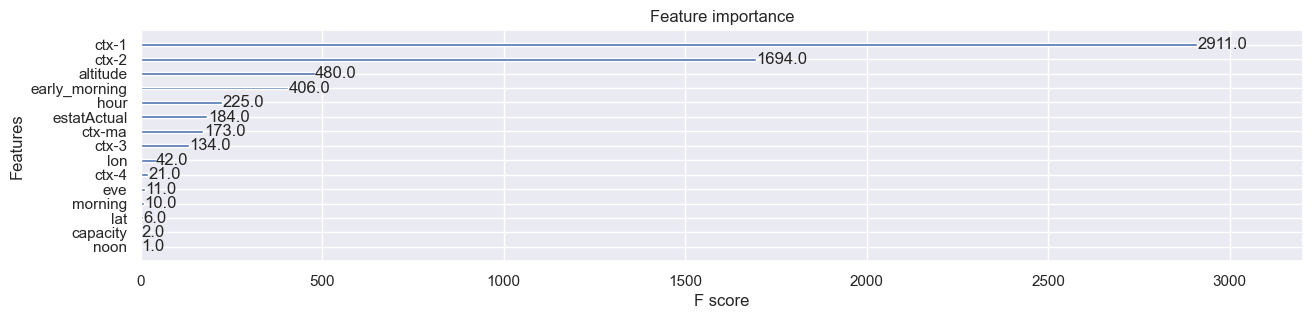

In [194]:
plot_importance(xgb_model)
plt.show()

In [82]:
thresholds = sorted(xgb_model.feature_importances_)[20:]
thresholds

[0.0,
 0.0,
 0.00062337884,
 0.0021539708,
 0.0021987504,
 0.0026807345,
 0.0035949545,
 0.003758436,
 0.003956393,
 0.004359829,
 0.009956199,
 0.01885058,
 0.14767624,
 0.24400516,
 0.55618536]

In [ ]:
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = xgb.XGBRFRegressor()
    selection_model.fit(select_X_train, Y_train)
    
    # eval model
    select_X_valid = selection.transform(X_valid)
    predictions = selection_model.predict(select_X_valid)
    
    rmse = mean_squared_error(Y_valid, predictions, squared=False)
    print("Thresh=%.5f, n=%d, RMSE: %.2f" % (thresh, select_X_train.shape[1], rmse))
    

In [195]:
selection = SelectFromModel(xgb_model, threshold=0.004, prefit=True)
select_X_train = selection.transform(X_train)

selection_model = xgb.XGBRFRegressor()
selection_model.fit(select_X_train, Y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, ...)

In [196]:
select_X_valid = selection.transform(X_valid)
rmse = mean_squared_error(Y_valid, selection_model.predict(select_X_valid), squared=False)

In [197]:
rmse

0.11433953679225678

### XGBoost

In [ ]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

In [ ]:
# Define final features and grid search with those small features --> store which is the threshold

### Linear Regression

In [228]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(select_X_train, Y_train)

LinearRegression()

In [229]:
P_valid_lr = lr_model.predict(select_X_valid)
mean_squared_error(Y_valid, P_valid_lr, squared=False)

0.11570307729555925

### NN

In [250]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras import regularizers, optimizers

In [260]:
model_dl = Sequential()

In [261]:
model_dl.add(Dense(256, input_shape=(None, 6), activation='relu'))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(128, activation='relu'))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(64, activation='relu'))
model_dl.add(Dropout(0.2))
model_dl.add(Dense(1, activation='relu'))

model_dl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, None, 256)         1792      
                                                                 
 dropout_5 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_8 (Dense)             (None, None, 128)         32896     
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 dense_9 (Dense)             (None, None, 64)          8256      
                                                                 
 dropout_7 (Dropout)         (None, None, 64)          0         
                                                                 
 dense_10 (Dense)            (None, None, 1)          

In [262]:
adam = optimizers.legacy.Adam(learning_rate=0.0005, decay=1e-2)
model_dl.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [ ]:
model_dl.fit(
    select_X_train, 
    Y_train, 
    epochs=10, 
    batch_size=1024, 
    validation_data=(select_X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/10
13091/13091 [==============================] - 48s 4ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 2/10
13091/13091 [==============================] - 46s 4ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 3/10
13091/13091 [==============================] - 46s 4ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 4/10
13091/13091 [==============================] - 45s 3ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 5/10
 2663/13091 [=====>........................] - ETA: 38s - loss: 0.0165 - mean_squared_error: 0.0165

# Test

In [ ]:
# Final model: combination of 3


# Predicting Sample Data

In [198]:
metadata = pd.read_csv('./metadata_sample_submission.csv')

In [199]:
sample = pd.merge(metadata, cluster_df)
sample.head()

,index,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,altitude,capacity,lat,lon,cluster_label
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,25.0,27.0,0.351465,0.483897,1
1,130,394,3,9,0,0.351852,0.549383,0.746914,0.783951,25.0,27.0,0.351465,0.483897,1
2,164,394,3,22,8,0.861111,0.839506,0.882716,0.783951,25.0,27.0,0.351465,0.483897,1
3,321,394,3,5,1,0.407407,0.404321,0.438272,0.817901,25.0,27.0,0.351465,0.483897,1
4,567,394,3,7,13,0.379630,0.197531,0.191358,0.697531,25.0,27.0,0.351465,0.483897,1


In [203]:
sample['ctx-ma'] = .0
# sample['ctx-ma'] = station_df.apply(lambda x: create_moving_average(x), axis=1)  --> not used at the end

### Handle Categorical

Handle the date time information.

In [204]:
sample.month = sample.month.astype('int')
sample.day = sample.day.astype('int')
sample.hour = sample.hour.astype('int')

In [205]:
sample['date_time'] = sample.apply(
    lambda x: datetime(
        2020, # will not be used
        int(x['month']), 
        int(x['day']), 
        int(x['hour'])
    ), axis=1)

sample['date'] = sample['date_time'].dt.date

In [210]:
sample['day_info'] = sample.date_time.apply(lambda x: get_day_info(x))
sample['hour_info'] = sample.date_time.apply(lambda x: get_hour_info(x))
sample['month_info'] = sample.date_time.apply(lambda x: get_month_info(x))

Handle covid cases

In [213]:
sample['confinment'] = 0
sample['covid_cases'] = COVID_CASES_IMPUTER_NULL

In [214]:
with tqdm(total=len(df_ecal)) as pbar:
    for idx, row in df_ecal.iterrows():    
        start_date, end_date = row['start_date'], row['end_date']
        
        for year in YEARS:
            holiday_start_date = date(year, start_date.month, start_date.day)
            holiday_end_date = date(year, end_date.month, end_date.day)
            range_dates = pd.date_range(holiday_start_date, holiday_end_date)
            
            for range_date in range_dates:
                sample.loc[
                    sample[(sample.month == range_date.month) & (sample.day == range_date.day)].index, 
                    'has_holiday'
                ] = 1

        pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 174.63it/s]


In [215]:
sample['has_holiday'] = sample['has_holiday'].fillna(0).astype('int')

In [216]:
sample[CATEGORICAL_FEATURES] = categorical_label_encoder.transform(sample[CATEGORICAL_COLUMNS]).toarray()

### Handle Numerical

For some numerical, we are going to put the mean of the numerical values that we have for the case of station and that variable.

In [217]:
sample = pd.merge(sample, df_numerical_features, left_on=('month', 'day', 'hour'), right_on=('month', 'day', 'hour'))

In [218]:
sample[NUMERICAL_FEATURES] = numeric_scaler.transform(sample[NUMERICAL_FEATURES])

In [254]:
select_sample = selection.transform(sample[FEATURES])
sample['percentage_docks_available'] = selection_model.predict(select_sample)

1719/1719 [==============================] - 0s 262us/step


In [225]:
# sample['percentage_docks_available'] = pd.DataFrame((lr_model.predict(sample[FEATURES]) * 2 + xgb_model.predict(sample[FEATURES])) / 3)
# sample

In [129]:
# sample_results = pd.DataFrame((lr_model.predict(sample[FEATURES]) + xgb_model.predict(sample[FEATURES]) * 2) / 3, columns=['percentage_docks_available']).reset_index()

In [255]:
sample_results = sample[['index', 'percentage_docks_available']]
sample_results

,index,percentage_docks_available
0,0,0.585867
1,50051,0.460989
2,15762,0.259060
3,26147,0.566522
4,49830,0.643318
...,...,...
54994,36769,0.664457
54995,50254,0.143637
54996,49029,0.194393
54997,20717,0.133985


In [256]:
sample_results.to_csv('sample_results.csv', header=True, index=False)